This notebook examines how genre list length correlates with gender.

The model that looks to be statistically significant splits the data into two bins: length $\leq 5$ and length $\geq 6$. For each bin, calculate
$$\frac{\text{actual # of male artists in bin}}{\text{expected # of male artists in bin}}$$
where the expected number of male artists in a bin is ${\% \text{male in total sample} \cdot \text{total in bin}}$. For the first bin, with the number of genre labels $\leq 5$, the ratio is $1$ within expected error rates. However, for the second bin, male artists are over represented and female artists are under represented.

- [x] look at how estimate of ratio expected/actual for each gender varies as the proportion of data used for the estimate grows from 10% to 100%, (possibly using CV for each estimate)
- [ ] add error bars showing 2*std

In [7]:
import numpy as np
import pandas as pd

seed = 23

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline
#%matplotlib notebook

from sklearn.model_selection import KFold

import re

from functools import partial

import plotly.graph_objects as go

Import the cleaned data:

In [8]:
%ls -lt ../../data/genre_lists/data_ready_for_model/

total 39824
-rw-r--r--  1 Daniel  staff    21724 Jun  9 11:47 genre_label_counts_TOTAL_2020-05-18-10-06.csv
-rw-r--r--@ 1 Daniel  staff   287510 Jun  4 13:42 genre_stats.html
-rw-r--r--@ 1 Daniel  staff   911587 Jun  4 13:39 genre_set_counts.html
-rw-r--r--@ 1 Daniel  staff     1845 Jun  4 13:11 female_bias_freq500.html
-rw-r--r--@ 1 Daniel  staff     1459 Jun  4 13:11 male_bias_freq500.html
-rw-r--r--  1 Daniel  staff    73746 May 29 10:19 genre_stats.csv
-rw-r--r--  1 Daniel  staff    66235 May 21 11:00 promiscuity_table.csv
-rw-r--r--  1 Daniel  staff    57474 May 20 12:47 corpus.mm.index
-rw-r--r--  1 Daniel  staff   382436 May 20 12:47 corpus.mm
-rw-r--r--  1 Daniel  staff    49966 May 20 12:47 genre_dictionary.dict
drwxr-xr-x  5 Daniel  staff      160 May 20 10:59 logistic_model_data/
-rw-r--r--  1 Daniel  staff    10926 May 18 11:10 genre_label_non-lonely_TRAINING_2020-05-18-10-06.csv
-rw-r--r--  1 Daniel  staff     8664 May 18 11:09 genre_label_lonely_TRAINING_2020-05-18-10-06.

In [9]:
%store -r now
now
#now = '2020-05-11-14-35'

'2020-05-18-10-06'

In [10]:
X_train = pd.read_csv('/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_X_train_{}.csv'.format(now), index_col = ['artist'])
y_train = pd.read_csv('/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_y_train_{}.csv'.format(now), index_col = ['artist'])

In [11]:
X_train.head()

,genrelist,genrelist_length
artist,,
Pablo_Holman,"['pop', 'rock', 'emo_pop']",3
Bobby_Edwards,['country'],1
La_Palabra,"['afro_cuban_jazz', 'son_montuno', 'guaracha',...",4
Sherrick,"['r_and_b', 'soul']",2
Allen_Collins,['southern_rock'],1


In [12]:
X_train.shape, y_train.shape

((12376, 2), (12376, 1))

In [13]:
data = y_train.join( [X_train], how = 'outer')

In [14]:
data.head()

,gender,genrelist,genrelist_length
artist,,,
Pablo_Holman,male,"['pop', 'rock', 'emo_pop']",3
Bobby_Edwards,male,['country'],1
La_Palabra,male,"['afro_cuban_jazz', 'son_montuno', 'guaracha',...",4
Sherrick,male,"['r_and_b', 'soul']",2
Allen_Collins,male,['southern_rock'],1


In [15]:
data.shape, data.isnull().sum()

((12376, 3),
 gender              0
 genrelist           0
 genrelist_length    0
 dtype: int64)

### Genre Labels

Each value of the genre column is a _string_ of comma separated genre labels. We want to convert it to a _list_ of strings.

In [16]:
"""This function takes in a string of the form
appearing in the genrelist of the dataframe.
It strips the square brackets and extra quotes and
returns a list of strings where each string is a genre label."""
def genrelist(string):
    string = string.strip("[").strip("]").replace("'","")
    L = [s for s in string.split(',')]
    L_new = []
    for x in L:
        L_new.append(x.replace(" ","_").lstrip("_").rstrip("_"))
    while (str("") in L_new):
        L_new.remove("")
    return L_new

Now we apply it to the whole column and put the lists in a new column:

In [17]:
data['genrelist']= data['genrelist'].apply(genrelist)

In [18]:
data.head()

,gender,genrelist,genrelist_length
artist,,,
Pablo_Holman,male,"[pop, rock, emo_pop]",3
Bobby_Edwards,male,[country],1
La_Palabra,male,"[afro_cuban_jazz, son_montuno, guaracha, salsa...",4
Sherrick,male,"[r_and_b, soul]",2
Allen_Collins,male,[southern_rock],1


### Extract unique genre labels: 

### This is for the training set:

In [19]:
# genre_list = data.genrelist.values.tolist()
# genre_list = [x for y in genre_list for x in y]
# genre_list = list(set(genre_list))

### Import the labels from the whole data set:

In [20]:
then = '2020-05-11-14-34'

In [21]:
genrelist_df = pd.read_csv('/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/genre_list_{}.csv'.format(now), index_col = 'Unnamed: 0')

In [22]:
data_male = data[data.gender == 'male']
data_female = data[data.gender == 'female']

In [23]:
tot = data.shape[0]
mal = data_male.shape[0]
fem = data_female.shape[0]
print('{} total artists'.format(tot))
print('There are {} unique genre labels.'.format(genrelist_df.shape[0]))
print('{} female artists, or {:0.0f}%'.format(fem, 100*fem/(fem+mal)))
print('{} male artists, or {:0.0f}%'.format(mal, 100*mal/(fem+mal)))

12376 total artists
There are 1494 unique genre labels.
3847 female artists, or 31%
8529 male artists, or 69%


## Calculate ratios of actual to expected for male and female using two bins for list lengths: <6 and >5 

### This function creates a DF with the frequencies of the lengths of lists by gender for a df of the type of "data" above. It is used in the bin_cv_est function below.

In [24]:
def create_length_counts_by_gender(df):
    """df is """
    
    #length counts total
    dft = df.groupby(['genrelist_length']).count()
    dft.drop(['gender'], axis = 1, inplace = True)
    dft.columns = ['artist_count']
    
    # length counts by gender
    df = df.groupby(['genrelist_length','gender']).count()
    df.columns = ['artist_count']

    df.reset_index(inplace = True)
    df.set_index(['genrelist_length'], inplace = True)
    df = df.pivot(columns = 'gender')
    
    #flatten index and replace with single strings
    df.columns = df.columns.to_flat_index()
    df.columns = [name[1] for name in df.columns]
    #combine total count with gender counts
    dft.columns = ['total']
    df = dft.join(df, how = 'outer')
    
    df.fillna(value = {'female': 0}, inplace = True)
    
    return df

In [25]:
lcbg = create_length_counts_by_gender(data)

In [26]:
lcbg

,total,female,male
genrelist_length,,,
1,3561,1031.0,2530.0
2,3067,1030.0,2037.0
3,2488,854.0,1634.0
4,1594,502.0,1092.0
5,850,243.0,607.0
6,462,127.0,335.0
7,181,27.0,154.0
8,92,15.0,77.0
9,37,9.0,28.0


### The bin_cv_est function estimates actual/expected ratios for male and female by genre list length by binning the data into < 6 and > 5 bins.

In [47]:
def bin_cv_est(df):
    
    # create length counts by gender
    lcbg = create_length_counts_by_gender(df)

    # mark rows by their class (uses ordering; could be done with masking)
    lcbg['classify'] = '1-5'
    lcbg.iloc[6:,-1] = '>5'

    # calculate totals for each bin
    twobins = lcbg.groupby(['classify']).agg('sum')

    # calculated columns: expected and ratios 
    twobins['expected female'] = (.31*twobins['total']).astype('int64')
    twobins['expected male'] = (.69*twobins['total']).astype('int64')
    twobins['male_act_exp_ratio'] =twobins['male']/ twobins['expected male']
    twobins['female_act_exp_ratio'] =  twobins['female']/ twobins['expected female']

    # only keep needed columns
    twobins = twobins[['male_act_exp_ratio','female_act_exp_ratio']]

    return twobins

## Calculate mean and std

In [48]:
twobins = bin_cv_est(data)

In [49]:
twobins

,male_act_exp_ratio,female_act_exp_ratio
classify,,
1-5,0.992767,1.016371
>5,1.204918,0.550459


In [50]:
def nested_subsamples(df,n):
    """input: a dataframe and an int (number of nested subsamples)
        output: an array of the sample sizes; a dictionary {subsample size: subsample},
        of nested subsamples
    """
    
    # make list of sample sizes for the nested subsamples
    sample_sizes = np.arange(df.shape[0]//n,(df.shape[0]),df.shape[0]//n)
    # make list of consecutive pairs
    pairs = list(zip(sample_sizes[:-1],sample_sizes[1:]))
    pairs.reverse()

    # name an empty dictionary, {subsample size: subsample}
    subsamples = {}
    # initialize with the largest subsample; dataframe is shuffled before taking the initial subsample
    subsamples[sample_sizes[-1]] = df.sample(df.shape[0]).sample(max(sample_sizes))
    # populate dictionary using pairs
    for sizes in pairs:
        subsamples[sizes[0]] = subsamples[sizes[1]].sample(sizes[0])
    
    return sample_sizes, subsamples

In [51]:
sample_sizes, subsamples = nested_subsamples(data,10)

In [52]:
sample_sizes

array([ 1237,  2474,  3711,  4948,  6185,  7422,  8659,  9896, 11133,
       12370])

In [53]:
subsamples[sample_sizes[5]]

,gender,genrelist,genrelist_length
artist,,,
Kamahl,male,"[pop, contemporary]",2
Houston_Stackhouse,male,"[delta_blues, country_blues]",2
Woody_Guthrie,male,"[country_folk, contemporary_folk, protest, wes...",6
Tommy_DeCarlo,male,"[rock, hard_rock]",2
Chris_Hart,male,[j_pop],1
...,...,...,...
Caitlin_Cary,female,[country],1
Lay_Low,female,"[alternative_country, folk, blues, rock]",4
Blaqstarr,male,"[hip_hop, baltimiddle_of_the_roade_club, dance]",3


### Calculate ratios for multiple nested subsamples along with the mean and std of the k runs

In [146]:
# choose the number of nested sequences for which to calculate the errors
k = 20
n = 20
# call the nested_subsamples function to calculate the sample_sizes
sample_sizes, subsamples = nested_subsamples(data, n)
# initialize an array to save the errors
indices = [sample_sizes.tolist(), ['1-5','>5']]
columns = [[f'run_{i}' for i in range(k)], ['female_act_exp_ratio','male_act_exp_ratio']]
biases = pd.DataFrame(index = pd.MultiIndex.from_product(indices), columns = pd.MultiIndex.from_product(columns), dtype = float)
for i in range(k):
    sample_sizes, subsamples = nested_subsamples(data, n)
    for size_ind, bin_ind in biases.index:
        twobins = bin_cv_est(subsamples[size_ind])
        biases.at[(size_ind, bin_ind),(f'run_{i}','female_act_exp_ratio')] = twobins.at[bin_ind,'female_act_exp_ratio']
        biases.at[(size_ind, bin_ind),(f'run_{i}','male_act_exp_ratio')] = twobins.at[bin_ind,'male_act_exp_ratio']

biases.index.names = ['size','bin']
biases.columns.names = ['runs','gender']

means = biases.groupby(['gender'], axis = 1).mean()
means.columns = pd.MultiIndex.from_product([['means'],['fem mean','mal mean']])
stds = biases.groupby(['gender'], axis = 1).std()
stds.columns = pd.MultiIndex.from_product([['stds'],['fem std','mal std']])
biases = biases.join([means, stds])

# fix these to be female/male
# biases[('mean','female_act_exp_ratio')] = biases.mean(axis = 1)
# biases['std'] = biases.std(axis = 1)
# err.index.name = 'size'

In [173]:
bias_means = biases[['means']]
bias_stds = biases[['stds']]

# Add in error bars with 2*std

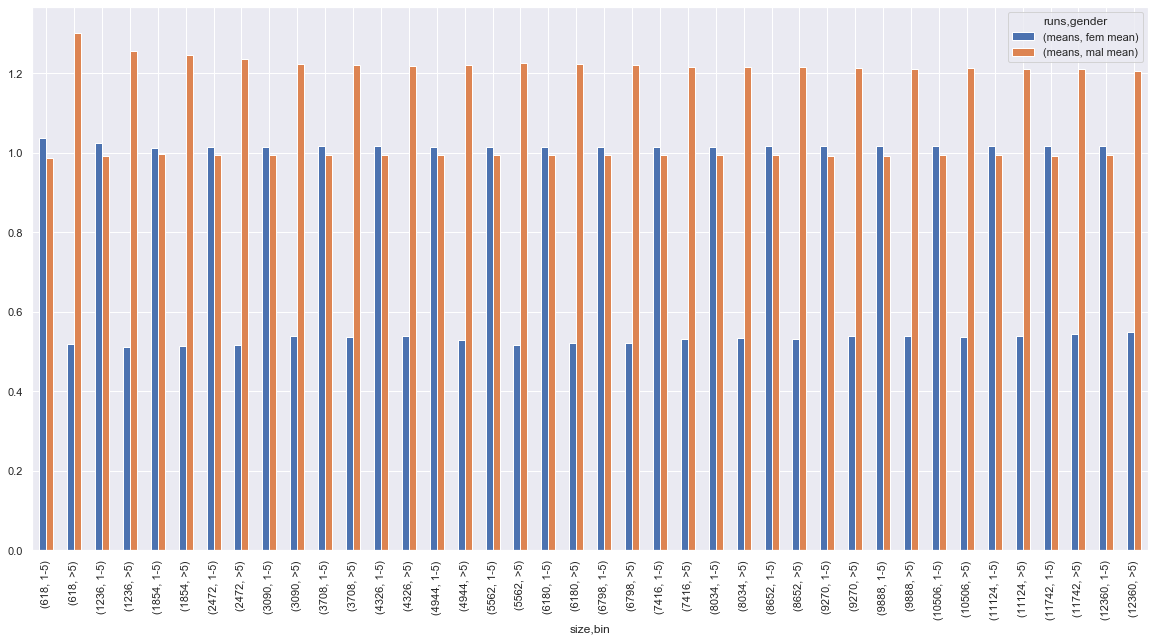

In [174]:
fig, ax = plt.subplots(1,1,figsize = (20,10))
bias_means.plot(use_index = True, kind = 'bar', ax = ax )
#ax.errorbar(, bias_means, yerr = bias_stds)

### Use below as model for adjusting the bargraph above

In [ ]:
df = twobins_folds_train_mean
eb = twobins_folds_train_std
fig, axs = plt.subplots(1,2, sharey = True, figsize = (10,10))
fig.suptitle('The ratio of actual to expected percentages of artists. The error bars show one STD', fontsize = 20)
axs[0].bar([0,1],df.iloc[0].to_list(), color = ['orange','purple'], yerr = eb.iloc[0].to_list(), capsize = 16)
axs[1].bar([0,1],df.iloc[1].to_list(), color = ['orange','purple'], yerr = eb.iloc[1].to_list(), capsize = 16)
axs[0].set_xticklabels([None,'male',None,'female'], fontsize = 16, rotation = 0)
axs[1].set_xticklabels([None,'male',None,'female'], fontsize = 16, rotation = 0)
axs[0].set_xlabel('1-5 genre labels', fontsize = 16)
axs[1].set_xlabel('6 or more genre labels', fontsize = 16)
axs[0].axhline(1, color = 'cyan', ls = '--')
axs[1].axhline(1, color = 'cyan', ls = '--')
plt.setp(axs[1].get_yticklabels(), visible=False)
#caption = 'This is'
#fig.text(caption)
fig.savefig(fname = '/Users/Daniel/Code/Genre/visualizations/twobins_plot.png', format = 'png', dpi = 'figure')